In [1]:
!pip install ultralytics
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing

In [2]:
from datasets import load_dataset
from PIL import Image
import os
import json
from tqdm import tqdm

# Load dataset dari Hugging Face
train_dataset = load_dataset("naver-clova-ix/cord-v2", split="train")
val_dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")

# Label map
label_map = {'item_name': 0, 'quantity': 1, 'price': 2, 'invoice': 3}

# Folder struktur YOLOv8
base_dir = "/kaggle/working/yolo_dataset"
for split in ['train', 'val']:
    os.makedirs(f"{base_dir}/images/{split}", exist_ok=True)
    os.makedirs(f"{base_dir}/labels/{split}", exist_ok=True)

# Fungsi konversi quadrilateral ke YOLO format
def quad_to_yolo(quad, img_w, img_h):
    x_coords = [quad[f'x{i}'] for i in range(1, 5)]
    y_coords = [quad[f'y{i}'] for i in range(1, 5)]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    x_center = (x_min + x_max) / 2.0 / img_w
    y_center = (y_min + y_max) / 2.0 / img_h
    width = (x_max - x_min) / img_w
    height = (y_max - y_min) / img_h

    return x_center, y_center, width, height

# Fungsi menyimpan data dalam format YOLOv8
def save_yolo_data(dataset, split):
    image_dir = os.path.join(base_dir, 'images', split)
    label_dir = os.path.join(base_dir, 'labels', split)

    for i, example in tqdm(enumerate(dataset), total=len(dataset), desc=f"Converting {split}"):
        parsed = json.loads(example['ground_truth'])
        gt_parse = parsed.get('gt_parse', {})
        image = example['image']
        img_w, img_h = image.size

        img_path = os.path.join(image_dir, f"{split}_{i:06d}.jpg")
        label_path = os.path.join(label_dir, f"{split}_{i:06d}.txt")
        image.save(img_path, format="JPEG")

        yolo_lines = []

        for item in gt_parse.get('menu', []):
            if not isinstance(item, dict):
                continue  # lewati item yang bukan dict
        
            item_name = item.get('nm', '')
            if isinstance(item_name, list):
                item_name = item_name[1] if item_name else ''
            item_name = str(item_name).strip().lower()
        
            quantity = str(item.get('cnt', '')).strip().lower()
            price = str(item.get('price', '')).strip().lower()

            for line in parsed.get('valid_line', []):
                words = line.get('words', [])
                text = ' '.join([w.get('text', '') for w in words]).strip().lower()

                if text in [item_name, quantity, price]:
                    cls_id = (
                        label_map['item_name'] if text == item_name else
                        label_map['quantity'] if text == quantity else
                        label_map['price']
                    )

                    quads = [w['quad'] for w in words if 'quad' in w]
                    if quads:
                        all_x = [q[f'x{i}'] for q in quads for i in range(1, 5)]
                        all_y = [q[f'y{i}'] for q in quads for i in range(1, 5)]
                        merged_quad = {
                            'x1': min(all_x), 'y1': min(all_y),
                            'x2': max(all_x), 'y2': min(all_y),
                            'x3': max(all_x), 'y3': max(all_y),
                            'x4': min(all_x), 'y4': max(all_y),
                        }

                        x_c, y_c, w, h = quad_to_yolo(merged_quad, img_w, img_h)
                        yolo_lines.append(f"{cls_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}")

        with open(label_path, "w") as f:
            f.write("\n".join(yolo_lines))

# Jalankan untuk train dan val
save_yolo_data(train_dataset, "train")
save_yolo_data(val_dataset, "val")

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

(…)-00000-of-00004-b4aaeceff1d90ecb.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00001-of-00004-7dbbe248962764c5.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

(…)-00002-of-00004-688fe1305a55e5cc.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

(…)-00003-of-00004-2d0cd200555ed7fd.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

(…)-00000-of-00001-cc3c5779fe22e8ca.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

(…)-00000-of-00001-9c204eb3f4e11791.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Converting val: 100%|██████████| 100/100 [00:05<00:00, 18.26it/s]


In [3]:
import shutil
from roboflow import Roboflow

print("📦 Mengunduh dataset dari Roboflow...")

rf = Roboflow(api_key="QYJz4fQRw4AUwlR6v8Wm")

print("📁 Dataset: 'invoice'")
project_invoice = rf.workspace("helmetproject-vmo6o").project("invoice-pr8ex")
version_invoice = project_invoice.version(1)
dataset_invoice = version_invoice.download("yolov8")  # -> contoh: /kaggle/working/InvoiceDetection-2

📦 Mengunduh dataset dari Roboflow...
📁 Dataset: 'invoice'
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Invoice-1 in yolov8:: 100%|██████████| 1778/1778 [00:00<00:00, 8680.32it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
import yaml

def cek_label_names(data_yaml_path):
    with open(data_yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    names = data.get('names', [])
    print("📋 Daftar Label:")
    for i, name in enumerate(names):
        print(f"  {i}: {name}")
    return names

data_yaml_path = os.path.join(dataset_invoice.location, "data.yaml")
label_names = cek_label_names(data_yaml_path)

📋 Daftar Label:
  0: -
  1: Invoice- NER detection - v1 2024-03-10 8-52am


In [5]:
def filter_labels_keep_only_class_0(label_dir, keep_class_id=0):
    kept_files = 0
    removed_lines = 0

    for file in os.listdir(label_dir):
        path = os.path.join(label_dir, file)
        if path.endswith('.txt') and os.path.isfile(path):
            with open(path, 'r') as f:
                lines = f.readlines()

            new_lines = [line for line in lines if line.strip().startswith(str(keep_class_id) + ' ')]
            removed = len(lines) - len(new_lines)

            if new_lines:
                with open(path, 'w') as f:
                    f.writelines(new_lines)
                kept_files += 1
                removed_lines += removed
            else:
                os.remove(path)  # Hapus file jika semua label dihapus

    print(f"✅ {kept_files} file disimpan dengan hanya label class {keep_class_id}.")
    print(f"🗑️ {removed_lines} baris label lain dibuang.")


# Dataset InvoiceDetection hanya pakai label "-"
filter_labels_keep_only_class_0(os.path.join(dataset_invoice.location, 'train', 'labels'))
filter_labels_keep_only_class_0(os.path.join(dataset_invoice.location, 'valid', 'labels'))

✅ 693 file disimpan dengan hanya label class 0.
🗑️ 4934 baris label lain dibuang.
✅ 65 file disimpan dengan hanya label class 0.
🗑️ 507 baris label lain dibuang.


In [6]:
def relabel_class_0_to_target(label_dir, new_class_id=3):
    for file in os.listdir(label_dir):
        path = os.path.join(label_dir, file)
        if path.endswith('.txt') and os.path.isfile(path):
            with open(path, 'r') as f:
                lines = f.readlines()

            new_lines = []
            for line in lines:
                parts = line.strip().split()
                if parts[0] == '0':
                    parts[0] = str(new_class_id)
                    new_lines.append(' '.join(parts))

            with open(path, 'w') as f:
                f.write('\n'.join(new_lines))

relabel_class_0_to_target(os.path.join(dataset_invoice.location, 'train', 'labels'), 3)
relabel_class_0_to_target(os.path.join(dataset_invoice.location, 'valid', 'labels'), 3)

In [7]:
# Struktur folder benar sesuai format Roboflow
for split in ['train', 'valid']: 
    for subfolder in ['images', 'labels']:
        src2 = os.path.join(dataset_invoice.location, split, subfolder)
        dst = os.path.join(base_dir, subfolder, split)

        os.makedirs(dst, exist_ok=True)

        for i, src in enumerate([src2], start=1):
            if os.path.exists(src):
                files = [f for f in os.listdir(src) if os.path.isfile(os.path.join(src, f))]
                print(f"🔄 Menyalin {len(files)} file dari sumber {i} ({split}/{subfolder})")
                for f in files:
                    shutil.copy(os.path.join(src, f), os.path.join(dst, f))
            else:
                print(f"⚠️ Folder tidak ditemukan: {src}")

print("✅ Selesai menggabungkan dataset.")

🔄 Menyalin 774 file dari sumber 1 (train/images)
🔄 Menyalin 693 file dari sumber 1 (train/labels)
🔄 Menyalin 73 file dari sumber 1 (valid/images)
🔄 Menyalin 65 file dari sumber 1 (valid/labels)
✅ Selesai menggabungkan dataset.


In [8]:
import yaml
import os

# Pastikan direktori /kaggle/working/ sudah ada (di Kaggle otomatis ada)
dataset_yaml = {
    'path': '/kaggle/working/yolo_dataset',
    'train': 'images/train',
    'val': 'images/val',
    'nc': 4,
    'names': {
        0: 'item_name',
        1: 'quantity',
        2: 'price',
        3: 'invoice',
    }
}

# Buat folder yolo_dataset jika belum ada
os.makedirs('/kaggle/working/yolo_dataset', exist_ok=True)

# Simpan dataset.yaml
with open('/kaggle/working/yolo_dataset/dataset.yaml', 'w') as f:
    yaml.dump(dataset_yaml, f, sort_keys=False)

In [9]:
import os
from collections import Counter

label_dir = '/kaggle/working/yolo_dataset/labels/train'  # ganti ke 'val' jika ingin validasi
label_counts = Counter()

for label_file in os.listdir(label_dir):
    if label_file.endswith(".txt"):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                if line.strip():  # skip baris kosong
                    class_id = int(line.split()[0])
                    label_counts[class_id] += 1

print("🔍 Total label yang ditemukan:")
for cls_id in sorted(label_counts):
    print(f"Class {cls_id}: {label_counts[cls_id]} objek")

total = sum(label_counts.values())
print(f"\n🧾 Total semua label: {total}")

🔍 Total label yang ditemukan:
Class 0: 1859 objek
Class 1: 6547 objek
Class 2: 2671 objek
Class 3: 717 objek

🧾 Total semua label: 11794


In [10]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

results = model.train(
    data = '/kaggle/working/yolo_dataset/dataset.yaml',
    batch = 24,
    epochs = 35,
    device = 0,
    lr0 = 3e-4,
    optimizer = 'AdamW',
    imgsz = 640,
    save_period = 10
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 78.2MB/s]


Ultralytics 8.3.127 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=24, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=35, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

100%|██████████| 755k/755k [00:00<00:00, 17.4MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.5MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 829.1±242.5 MB/s, size: 70.0 KB)


train: Scanning /kaggle/working/yolo_dataset/labels/train... 1493 images, 427 backgrounds, 0 corrupt: 100%|██████████| 1574/1574 [00:01<00:00, 1514.71it/s]

train: /kaggle/working/yolo_dataset/images/train/train_000000.jpg: 294 duplicate labels removed
train: /kaggle/working/yolo_dataset/images/train/train_000001.jpg: 30 duplicate labels removed
train: /kaggle/working/yolo_dataset/images/train/train_000002.jpg: 6 duplicate labels removed
train: /kaggle/working/yolo_dataset/images/train/train_000003.jpg: 6 duplicate labels removed
train: /kaggle/working/yolo_dataset/images/train/train_000005.jpg: 20 duplicate labels removed
train: /kaggle/working/yolo_dataset/images/train/train_000006.jpg: 2 duplicate labels removed
train: /kaggle/working/yolo_dataset/images/train/train_000008.jpg: 2 duplicate labels removed
train: /kaggle/working/yolo_dataset/images/train/train_000011.jpg: 8 duplicate labels removed
train: /kaggle/working/yolo_dataset/images/train/train_000012.jpg: 12 duplicate labels removed
train: /kaggle/working/yolo_dataset/images/train/train_000013.jpg: 12 duplicate labels removed
train: /kaggle/working/yolo_dataset/images/train/train

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 499.3±50.6 MB/s, size: 246.5 KB)


val: Scanning /kaggle/working/yolo_dataset/labels/val... 100 images, 46 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 1922.20it/s]

val: /kaggle/working/yolo_dataset/images/val/val_000000.jpg: 6 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/val_000006.jpg: 8 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/val_000010.jpg: 2 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/val_000011.jpg: 6 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/val_000013.jpg: 2 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/val_000015.jpg: 2 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/val_000018.jpg: 2 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/val_000019.jpg: 6 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/val_000021.jpg: 12 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/val_000024.jpg: 30 duplicate labels removed
val: /kaggle/working/yolo_dataset/images/val/val_000025.jpg: 30 duplicate labels removed
val: /kaggle/working/yolo_dat

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.0003, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005625000000000001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      3.85G      1.766      2.998      1.353         79        640: 100%|██████████| 66/66 [00:17<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

                   all        100        555      0.228      0.352      0.248      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      4.09G      1.327      1.642      1.104         88        640: 100%|██████████| 66/66 [00:15<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

                   all        100        555      0.593      0.284      0.435       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      4.38G      1.258      1.442      1.073        134        640: 100%|██████████| 66/66 [00:15<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]

                   all        100        555       0.59      0.651      0.619      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      4.38G      1.205      1.335      1.049        119        640: 100%|██████████| 66/66 [00:15<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]

                   all        100        555      0.614       0.67      0.647      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      4.38G      1.206      1.233      1.033        107        640: 100%|██████████| 66/66 [00:15<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all        100        555      0.645       0.74      0.703      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      4.38G      1.141      1.179      1.015         46        640: 100%|██████████| 66/66 [00:15<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]

                   all        100        555      0.664      0.676      0.699      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35      4.38G      1.156      1.107      1.007         74        640: 100%|██████████| 66/66 [00:15<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

                   all        100        555      0.726      0.731      0.747      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      4.38G      1.114      1.069      1.003         50        640: 100%|██████████| 66/66 [00:15<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]

                   all        100        555      0.732      0.703      0.761      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      4.38G      1.105      1.055     0.9937        100        640: 100%|██████████| 66/66 [00:16<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]

                   all        100        555      0.721      0.794      0.786      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      4.38G      1.063      0.999     0.9864         54        640: 100%|██████████| 66/66 [00:16<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

                   all        100        555      0.672       0.78      0.772      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      4.38G      1.062      0.978     0.9739        152        640: 100%|██████████| 66/66 [00:15<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]

                   all        100        555       0.73      0.824      0.805      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      4.38G      1.033     0.9518     0.9677         58        640: 100%|██████████| 66/66 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]

                   all        100        555      0.687      0.841      0.791      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      4.38G      1.055     0.9411      0.965        104        640: 100%|██████████| 66/66 [00:15<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

                   all        100        555      0.721      0.841      0.807      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      4.38G      1.017     0.9084     0.9588         85        640: 100%|██████████| 66/66 [00:16<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.51it/s]

                   all        100        555      0.767      0.797      0.815      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      4.38G      1.014     0.8911     0.9594         90        640: 100%|██████████| 66/66 [00:15<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.77it/s]

                   all        100        555      0.763      0.809      0.839       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      4.38G      1.012     0.8808     0.9528        164        640: 100%|██████████| 66/66 [00:16<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

                   all        100        555      0.731      0.816      0.847      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      4.85G     0.9921     0.8979     0.9586         87        640: 100%|██████████| 66/66 [00:15<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.58it/s]

                   all        100        555      0.783      0.752      0.823       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      4.85G      1.008     0.8637     0.9547         98        640: 100%|██████████| 66/66 [00:16<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

                   all        100        555      0.753      0.826      0.853      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35      4.85G     0.9752     0.8345     0.9396        169        640: 100%|██████████| 66/66 [00:15<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]

                   all        100        555      0.775      0.816      0.844      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      4.85G     0.9773     0.8238     0.9411         67        640: 100%|██████████| 66/66 [00:16<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]

                   all        100        555      0.751      0.851       0.86      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      4.85G     0.9637     0.8211     0.9463         70        640: 100%|██████████| 66/66 [00:15<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

                   all        100        555      0.812      0.808       0.87      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      4.85G     0.9407     0.7885     0.9407        150        640: 100%|██████████| 66/66 [00:16<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

                   all        100        555      0.826      0.829      0.882      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      4.85G     0.9396      0.807     0.9372         51        640: 100%|██████████| 66/66 [00:15<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

                   all        100        555      0.755      0.859      0.861      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      4.85G     0.9164     0.7875     0.9292        103        640: 100%|██████████| 66/66 [00:16<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]

                   all        100        555      0.784      0.849      0.875      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      4.85G      0.954     0.7757     0.9372         62        640: 100%|██████████| 66/66 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all        100        555      0.782      0.857       0.87      0.588


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      4.85G     0.8883     0.7244     0.9181         49        640: 100%|██████████| 66/66 [00:17<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]

                   all        100        555      0.787      0.865      0.872      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      4.85G     0.8761     0.7127      0.919        103        640: 100%|██████████| 66/66 [00:15<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.91it/s]

                   all        100        555      0.799       0.87      0.891      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      4.85G     0.8672     0.6915     0.9148         60        640: 100%|██████████| 66/66 [00:15<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]

                   all        100        555      0.799      0.837      0.884      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      4.85G     0.8468     0.6699     0.9082         64        640: 100%|██████████| 66/66 [00:15<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]

                   all        100        555      0.793      0.829      0.873      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      4.85G     0.8391     0.6599     0.9065         26        640: 100%|██████████| 66/66 [00:15<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.03it/s]

                   all        100        555      0.793      0.857      0.896       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      4.85G     0.8354     0.6615     0.9118         53        640: 100%|██████████| 66/66 [00:15<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.08it/s]

                   all        100        555      0.781      0.873      0.888      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      4.85G     0.8201     0.6486     0.9017         61        640: 100%|██████████| 66/66 [00:15<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.95it/s]

                   all        100        555      0.799      0.861      0.897       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35      4.85G     0.8164     0.6307     0.9035         45        640: 100%|██████████| 66/66 [00:15<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]

                   all        100        555      0.814      0.857      0.894      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      4.85G     0.8212     0.6398     0.9084         37        640: 100%|██████████| 66/66 [00:15<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

                   all        100        555      0.801      0.865      0.896      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35      4.85G     0.8167     0.6254     0.9022         46        640: 100%|██████████| 66/66 [00:15<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.86it/s]

                   all        100        555        0.8       0.88      0.897       0.62



35 epochs completed in 0.163 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.127 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


                   all        100        555      0.801      0.863      0.897       0.62
             item_name         54        175      0.725      0.891      0.885      0.664
              quantity         52        180      0.802      0.764      0.841      0.441
                 price         54        200      0.875      0.935      0.966      0.755


invalid value encountered in less
invalid value encountered in less


Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Path ke hasil training
results_csv_path = "/kaggle/working/runs/detect/train/results.csv"

# Baca file CSV
df = pd.read_csv(results_csv_path)

# Tampilkan kolom-kolom tersedia
print(df.columns)

Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


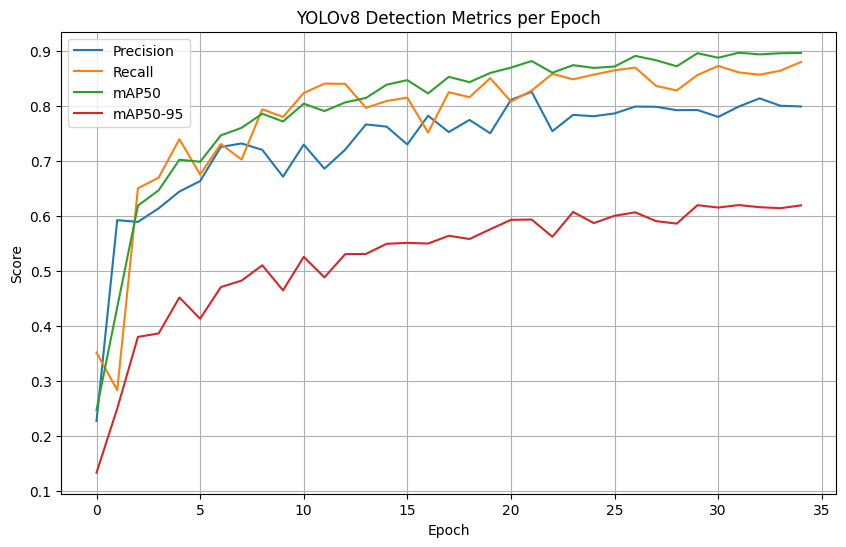

In [12]:
# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Now, try plotting again
plt.figure(figsize=(10,6))
plt.plot(df['metrics/precision(B)'], label='Precision')
plt.plot(df['metrics/recall(B)'], label='Recall')
plt.plot(df['metrics/mAP50(B)'], label='mAP50')
plt.plot(df['metrics/mAP50-95(B)'], label='mAP50-95')
plt.title("YOLOv8 Detection Metrics per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

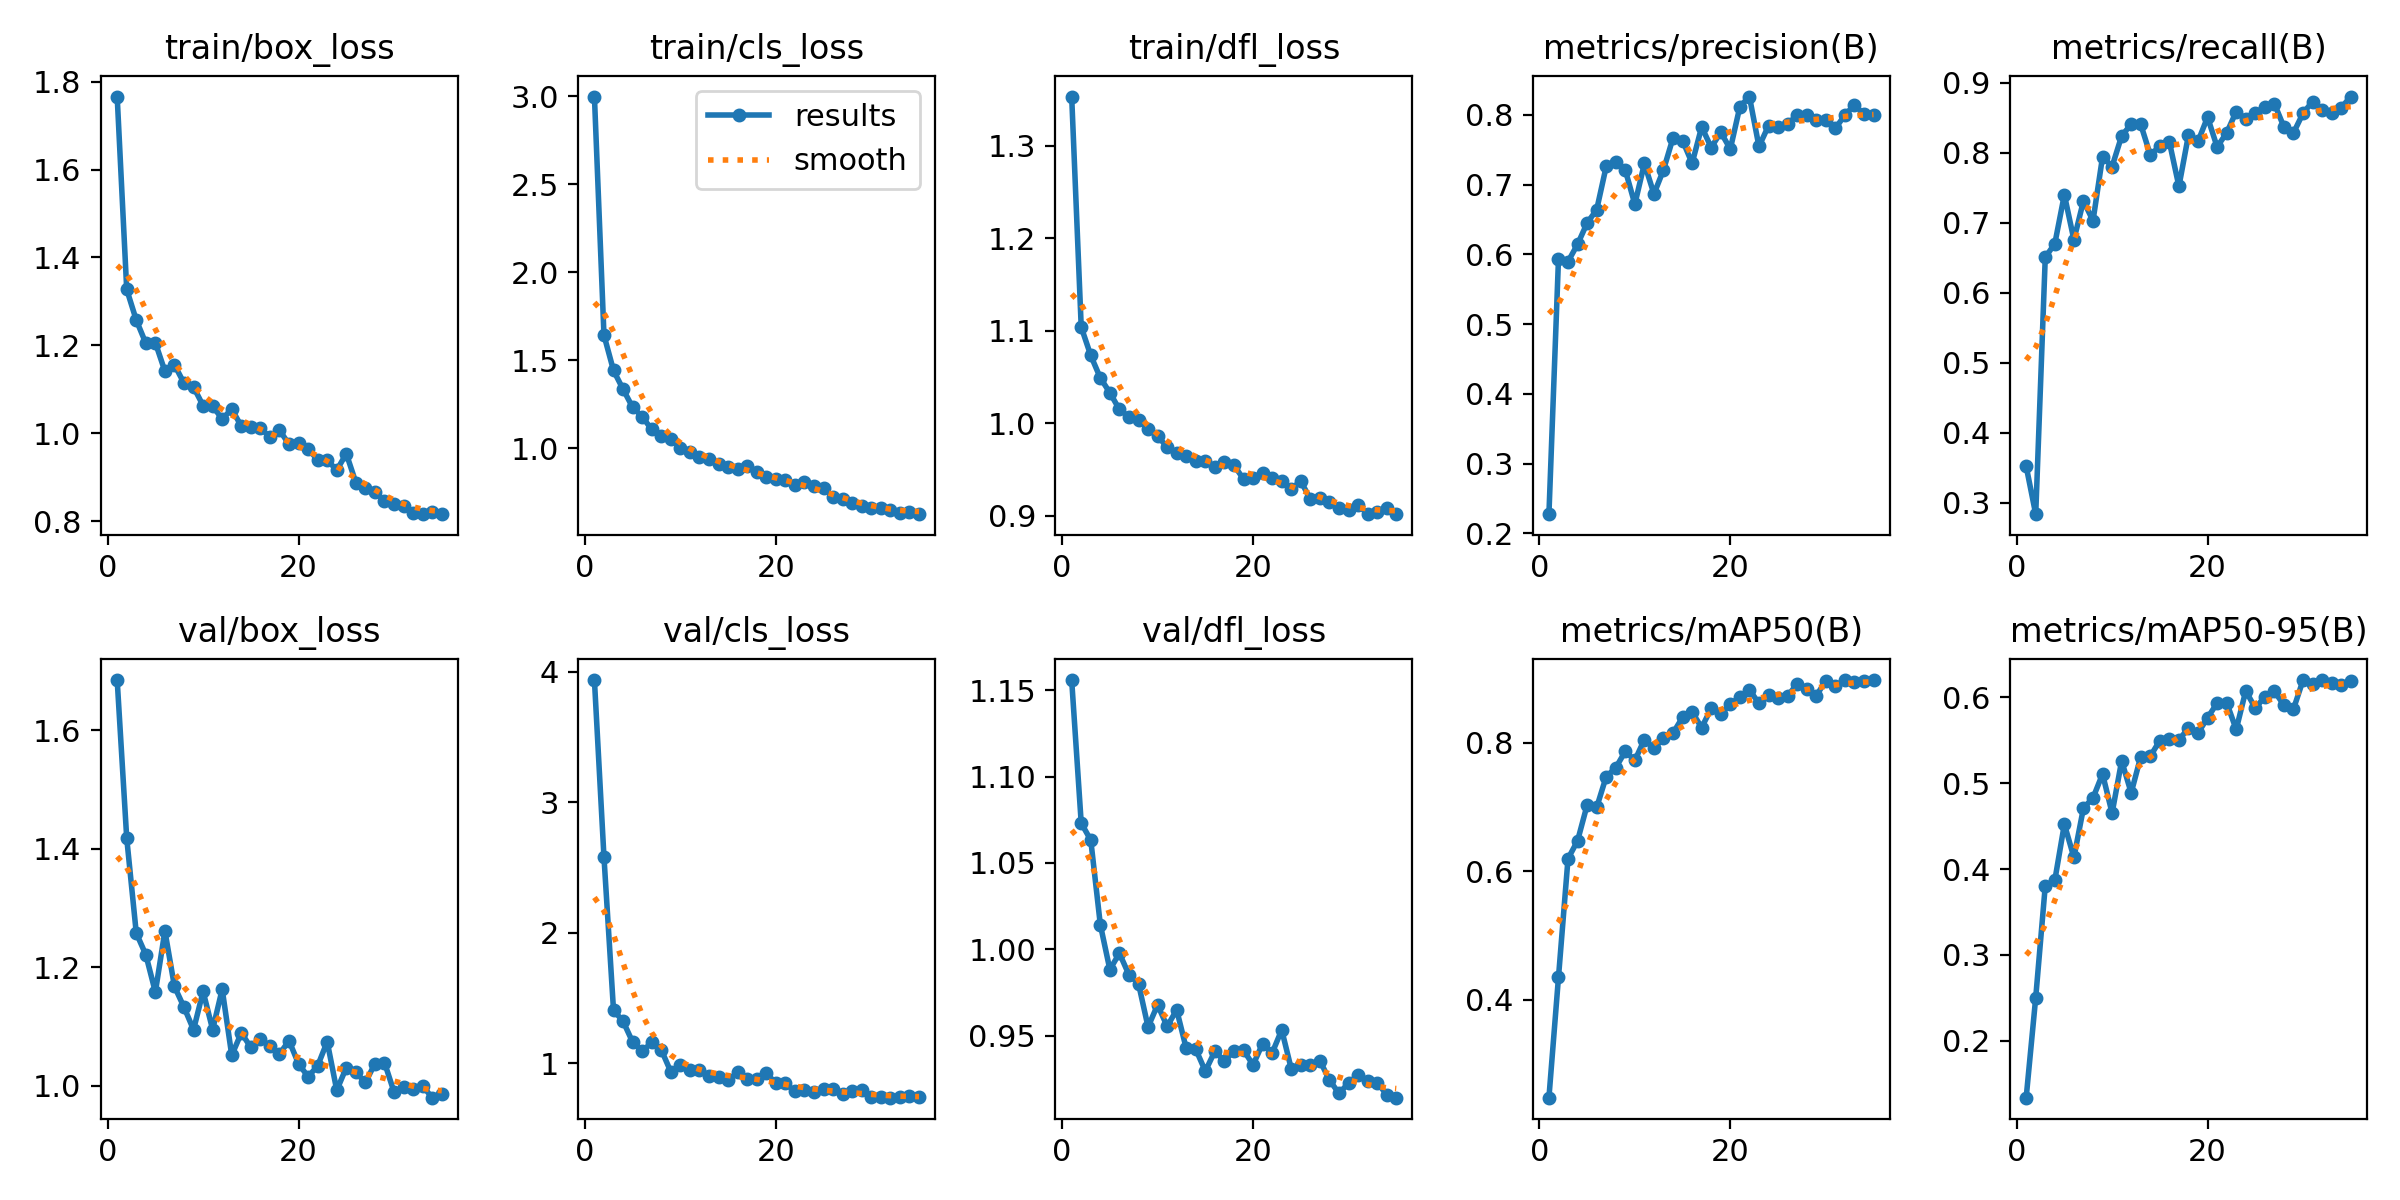

In [13]:
from PIL import Image
from IPython.display import display

img = Image.open("/kaggle/working/runs/detect/train/results.png")
display(img)

In [14]:
from ultralytics import YOLO

model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")


0: 640x640 6 item_names, 5 quantitys, 6 prices, 5.8ms
Speed: 2.5ms preprocess, 5.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


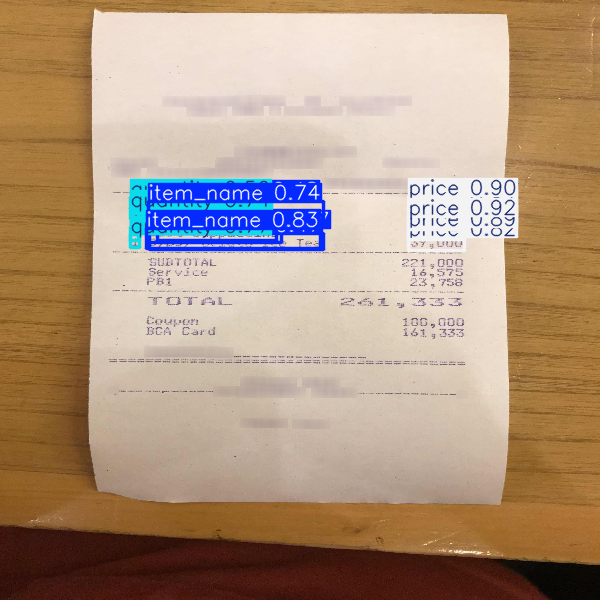

In [15]:
import cv2
import numpy as np

dataset = load_dataset("naver-clova-ix/cord-v2", split="train")
image_path = dataset[5]['image']  # Sudah dalam bentuk PIL.Image
image_np = cv2.cvtColor(np.array(image_path), cv2.COLOR_RGB2BGR)
image_resized = cv2.resize(image_np, (600, 600))

results = model(image_resized)  # Ganti dengan path gambar kamu


# Tampilkan hasilnya
results[0].show()

In [16]:
for result in results:
    boxes = result.boxes  # bounding boxes
    probs = result.probs  # klasifikasi probabilitas (jika ada)
    print(boxes.xyxy)     # koordinat [x1, y1, x2, y2]
    print(boxes.conf)     # confidence score
    print(boxes.cls)      # class index

tensor([[408.1678, 216.3865, 464.1143, 229.8482],
        [408.9704, 196.6966, 463.6772, 210.2776],
        [408.2164, 227.1169, 464.4091, 239.8748],
        [408.0594, 207.7334, 463.8960, 221.2744],
        [146.4001, 228.5932, 320.9730, 248.5830],
        [408.3305, 237.3739, 464.4984, 250.4714],
        [130.1081, 234.2756, 139.3549, 247.5247],
        [148.1282, 201.1754, 323.5062, 222.0001],
        [130.5673, 208.7816, 138.5460, 218.6208],
        [130.2139, 227.1895, 138.9536, 240.6013],
        [131.0410, 216.0482, 139.2367, 227.6631],
        [130.6044, 197.0599, 138.8006, 208.2517],
        [146.8031, 198.4179, 214.7032, 211.8842],
        [149.0524, 233.8777, 323.5145, 249.9183],
        [147.4599, 227.1794, 281.9307, 242.9978],
        [408.1032, 222.2455, 464.3606, 238.9478],
        [157.5731, 228.7463, 276.0202, 240.1669]], device='cuda:0')
tensor([0.9161, 0.8983, 0.8943, 0.8722, 0.8345, 0.8173, 0.7662, 0.7427, 0.7418, 0.6573, 0.6384, 0.5047, 0.4756, 0.4734, 0.4684, 0.41

In [17]:
for box in results[0].boxes:
    print(box.xyxy, box.conf, box.cls)

tensor([[408.1678, 216.3865, 464.1143, 229.8482]], device='cuda:0') tensor([0.9161], device='cuda:0') tensor([2.], device='cuda:0')
tensor([[408.9704, 196.6966, 463.6772, 210.2776]], device='cuda:0') tensor([0.8983], device='cuda:0') tensor([2.], device='cuda:0')
tensor([[408.2164, 227.1169, 464.4091, 239.8748]], device='cuda:0') tensor([0.8943], device='cuda:0') tensor([2.], device='cuda:0')
tensor([[408.0594, 207.7334, 463.8960, 221.2744]], device='cuda:0') tensor([0.8722], device='cuda:0') tensor([2.], device='cuda:0')
tensor([[146.4001, 228.5932, 320.9730, 248.5830]], device='cuda:0') tensor([0.8345], device='cuda:0') tensor([0.], device='cuda:0')
tensor([[408.3305, 237.3739, 464.4984, 250.4714]], device='cuda:0') tensor([0.8173], device='cuda:0') tensor([2.], device='cuda:0')
tensor([[130.1081, 234.2756, 139.3549, 247.5247]], device='cuda:0') tensor([0.7662], device='cuda:0') tensor([1.], device='cuda:0')
tensor([[148.1282, 201.1754, 323.5062, 222.0001]], device='cuda:0') tensor([